In [75]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
import math
import pandas as pd
import xgboost
import lightgbm
import catboost

from matplotlib.colors import ListedColormap
from scipy.stats import pearsonr
from scipy.special import comb
from itertools import combinations
from sklearn.base import BaseEstimator
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.ensemble import (RandomForestClassifier,
                              ExtraTreesClassifier,
                              VotingClassifier)
from sklearn.tree import (DecisionTreeRegressor,
                          DecisionTreeClassifier)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

In [2]:
plt.rcParams["figure.figsize"] = 12, 9
sns.set_style("whitegrid")
warnings.filterwarnings("ignore")

SEED = 111
random.seed(SEED)
np.random.seed(SEED)

### Задание 1. Bias-variance trade-off

**2 балла**

Продемонстрируйте bias-variance trade-off для `DecisionTreeRegressor` при изменении глубины дерева. Постройте регрессионную модель функции от одной независимой переменной, представленной в ячейке ниже, используя функцию `plot_regression_predictions` (можете ее как-то поменять, если захочется). Попробуйте разные значения глубины деревьев, при каком значении, на ваш взгляд, модель оптимальна, при каком variance становится слишком большим?

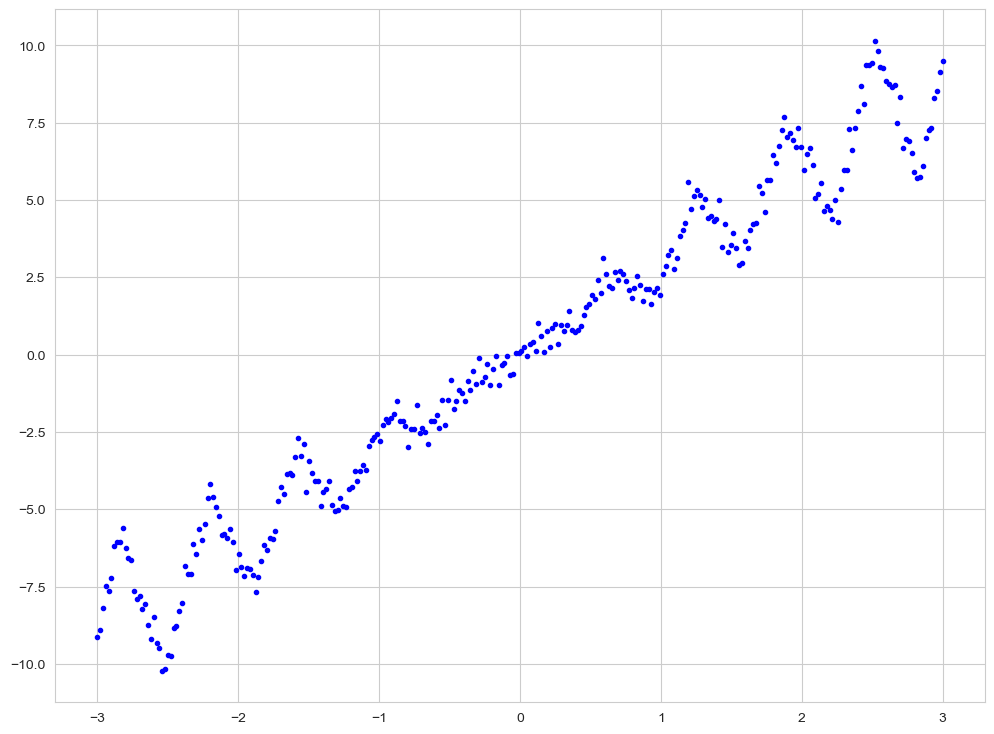

In [3]:
# Сгенерируем какую-нибудь необычную зависимость и научимся ее предсказывать
np.random.seed(42)
m = 300
X = np.linspace(-3, 3, m).reshape(-1, 1)
y = (3 + 2/np.pi * np.arcsin(np.cos(10 * X))) * X
y = y + np.random.randn(m, 1) / 3
plt.plot(X.reshape(-1), y.reshape(-1), "b.");

In [4]:
# Функция для отрисовки предсказаний деревьев решений в случае регрессии
def plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel="$y$"):
    x1 = np.linspace(axes[0], axes[1], 500).reshape(-1, 1)
    y_pred = tree_reg.predict(x1)
    plt.axis(axes)
    plt.xlabel("$x$", fontsize=12)
    if ylabel:
        plt.ylabel(ylabel, fontsize=18, rotation=0)

    plt.plot(x1, y_pred, linewidth=2, label=r"$\hat{y}$")

Изобразите, как меняются предсказания дерева при увеличении максимальной глубины (можно взять что-то в диапазоне от 1 до 15):

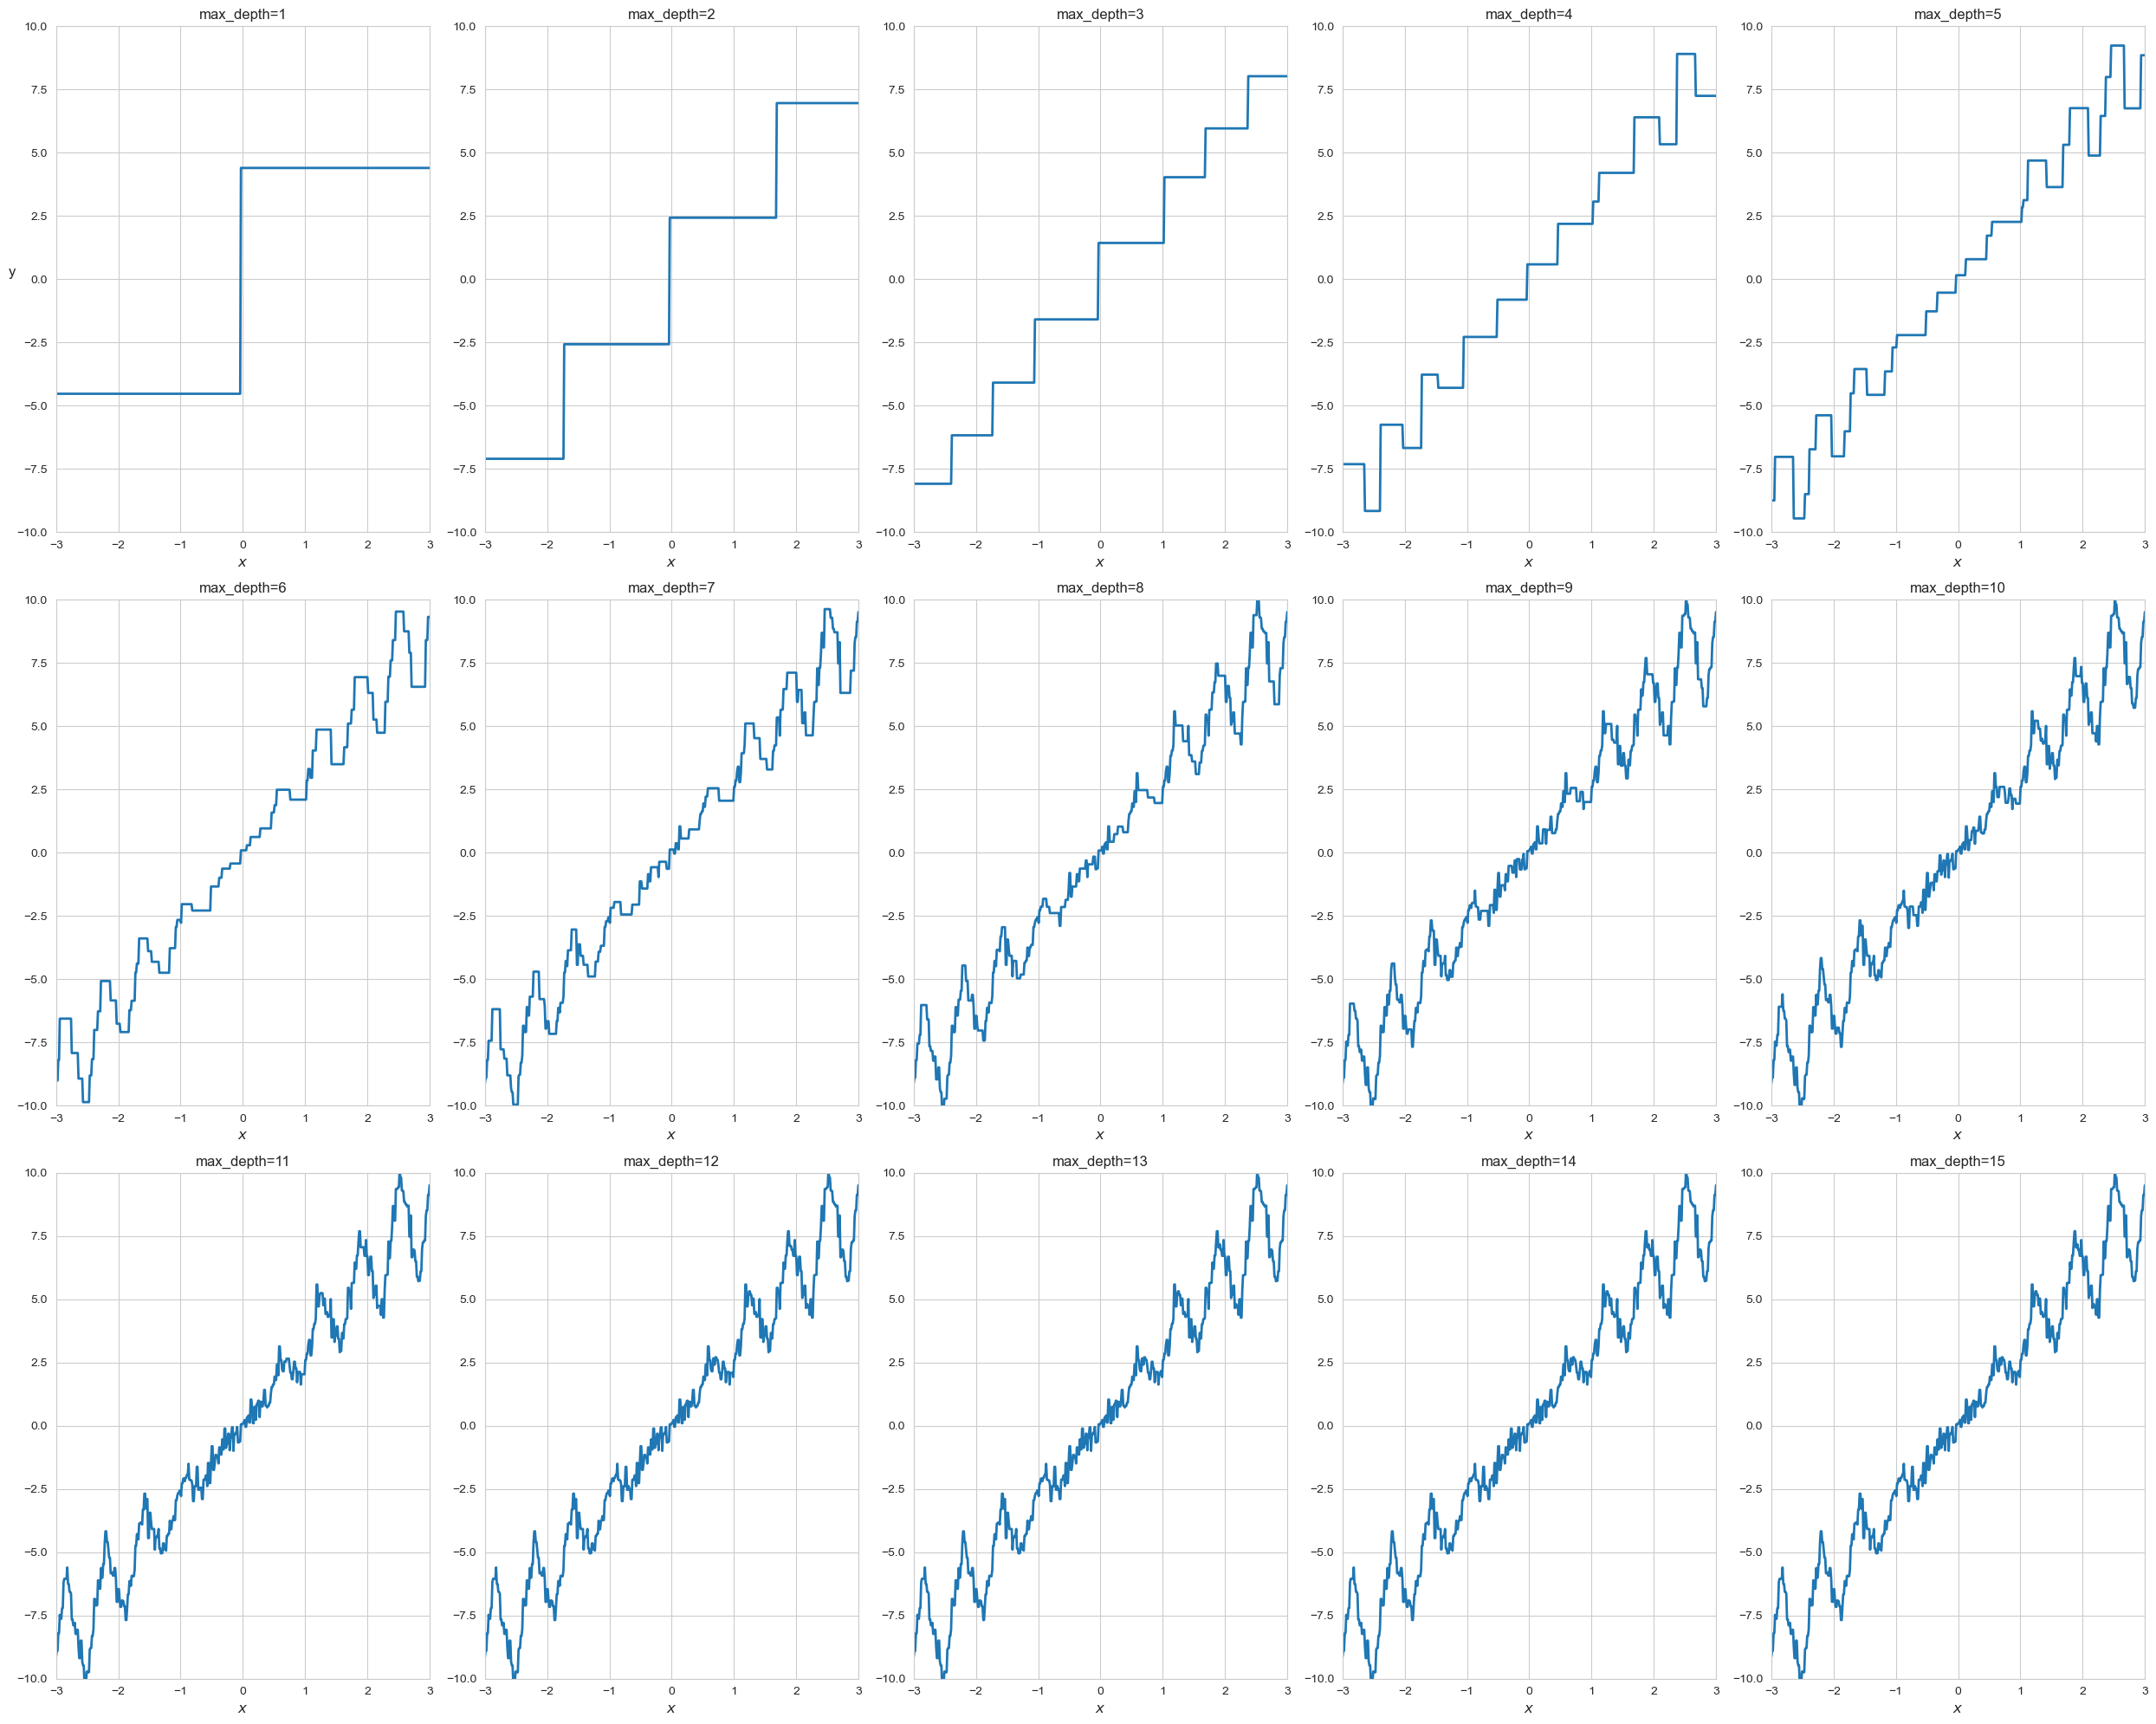

In [5]:
plt.figure(figsize=(25, 20))
for max_depth in range(1, 16):
    tree_reg = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    tree_reg.fit(X, y)
    plt.subplot(3, 5, max_depth)
    if max_depth == 1:
        plt.ylabel("y", fontsize=12, rotation=0)
    plot_regression_predictions(tree_reg, X, y, axes=[-3, 3, -10, 10], ylabel=None)
    plt.title("max_depth={}".format(max_depth), fontsize=12)

plt.tight_layout()
plt.show()

### Задание 2. Random forest

Теперь давайте немного подготовимся к тому, чтобы реализовать свой собственный случайный лес, а потом реализуем его.

#### Задание 2. 1. Простое ансамблирование

**1 балла**

Представим, что у нас есть 101 классификатор. Каждый может с вероятностью `p` (равной для всех моделей) правильно предсказать класс объекта. Будем делать предсказания по большинству голосов (majority vote). Постройте зависимость вероятности правильно классифицировать объект от значения `p`. Вам может быть полезная следующая формула:

$$ \large \mu = \sum_ {i = 51} ^ {101} C_{101} ^ ip ^ i (1-p) ^ {101-i} $$

In [6]:
def probability_correct_classification(n, p):
    prob = 0
    for k in range(n // 2 + 1, n + 1):
        prob += comb(n, k) * (p ** k) * ((1 - p) ** (n - k))
    return prob

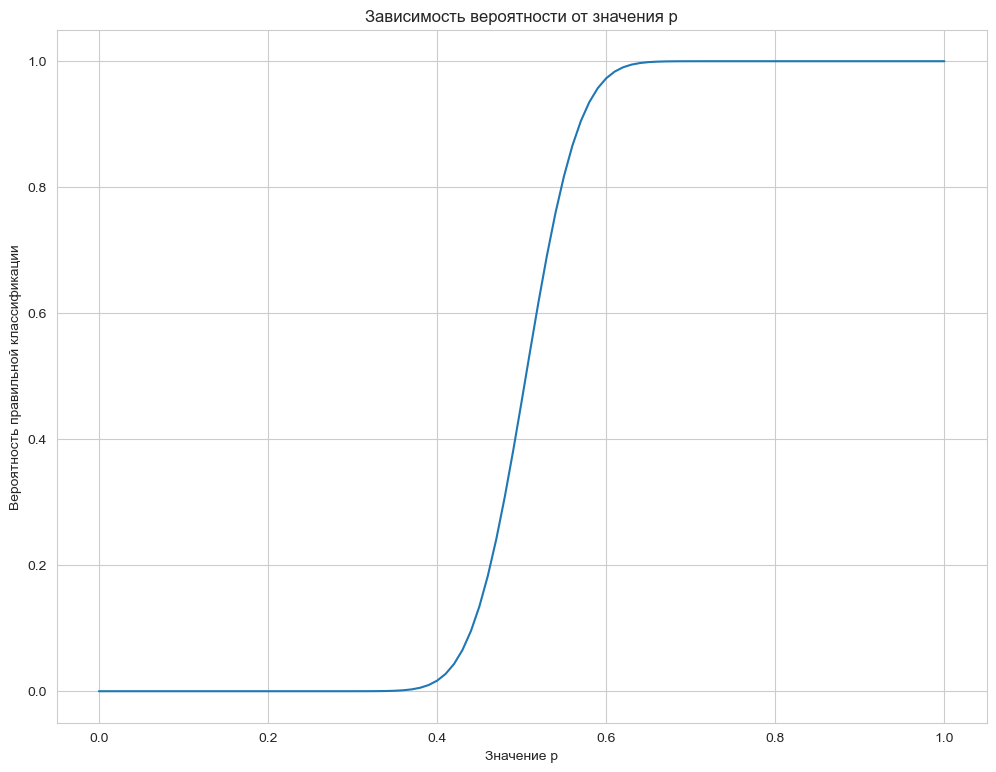

In [7]:
p_values = np.arange(0, 1.01, 0.01)

probabilities = [probability_correct_classification(n=100, p=p) for p in p_values]

plt.plot(p_values, probabilities)
plt.xlabel('Значение p')
plt.ylabel('Вероятность правильной классификации')
plt.title('Зависимость вероятности от значения p')
plt.grid(True)
plt.show()

А теперь давайте посмотрим на другую ситуацию. У нас есть фиксированная вероятность того, что модель правильно классифицирует объект `p = 0.65`. Постройте зависимость вероятности правильно классифицировать объект от числа моделей в ансамбле.

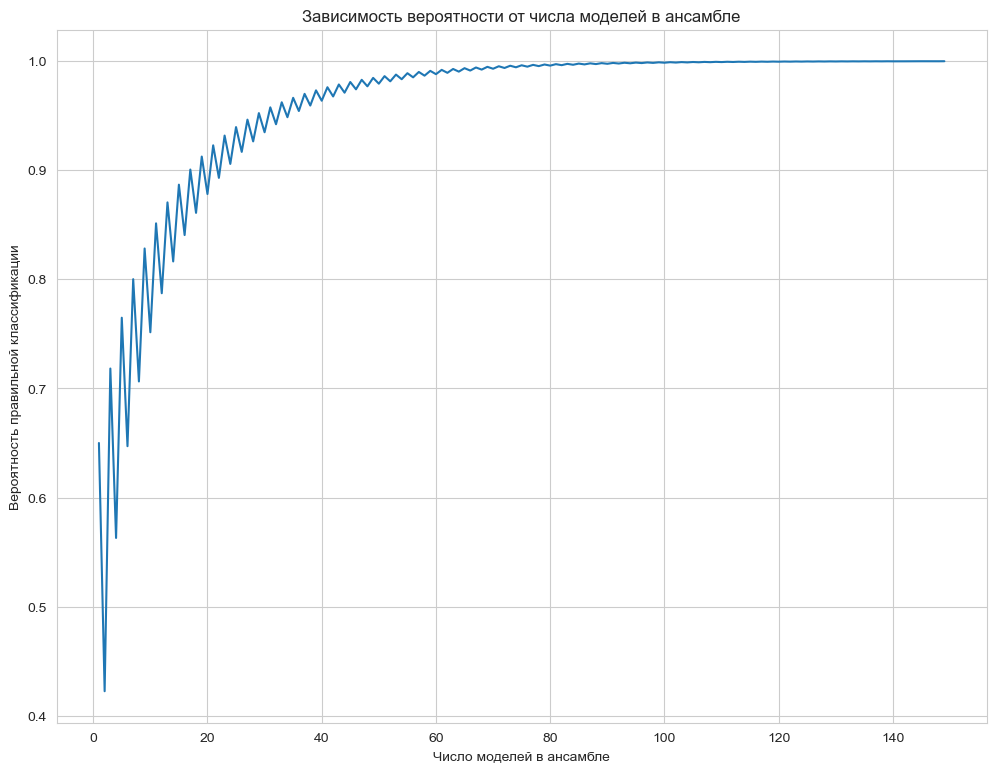

In [8]:
n_values = np.arange(1, 150)
probabilities = [probability_correct_classification(n=n, p=0.65) for n in n_values]

plt.plot(n_values, probabilities)
plt.xlabel('Число моделей в ансамбле')
plt.ylabel('Вероятность правильной классификации')
plt.title('Зависимость вероятности от числа моделей в ансамбле')
plt.grid(True)
plt.show()

Опишите ваши наблюдения:

* При малых значениях p вероятность правильной классификации объекта низкая, так как модели в ансамбле вероятнее будут ошибаться при предсказании класса. Это объясняется тем, что каждая модель в ансамбле по отдельности вносит вклад в правильное предсказание с меньшей вероятностью. По мере увеличения значения p вероятность правильной классификации также растет. При p = 1.0 модели всегда правильно предсказывают класс. График демонстрирует плавный рост вероятности правильной классификации с увеличением значения p.


* При небольшом количестве моделей в ансамбле вероятность правильной классификации объекта низкая, так как ансамбль слишком мал. С увеличением числа моделей в ансамбле вероятность правильной классификации растет (связано с тем, что при большем количестве моделей вероятность того, что большинство моделей правильно классифицируют объект, увеличивается). Однако существует точка, после которой увеличение числа моделей перестает значительно влиять на вероятность правильной классификации, и график выходит на плато.


#### Задание 2. 2. Реализация простого RF

**4 балла**

Реализуйте свой собственный класс `RandomForestClassifierCustom`, используя в качестве базовой модели `DecisionTreeClassifier` из `sklearn`.

Небольшое описание:
- Используйте приведенный ниже код
- В методе `fit` в цикле (`i` от 0 до `n_estimators-1`):
    * Зафиксируйте генератор случайных чисел следующим образом np.random.seed(`random_state + i`). Идея в том, что на каждой итерации у нас будет новое значение для генератора случайных чисел, что добавит побольше "случайности", но в то же время мы сможем иметь воспроизводимые результаты
    * После чего выберите `max_features` признаков **без возвращения/without replacement**, сохраните список выбранных признаков (их индексов) в `self.feat_ids_by_tree`
    * Также создайте псевдовыборку при помощи бутстрэпа (выбор **с возвращением/with replacement**) из тренировочных данных. Может помочь функция `np.random.choice` и ее аргумент `replace`
    * Обучите дерево решений с параметрами, заданными в конструкторе класса `max_depth`, `max_features` и `random_state` на полученной псевдовыборке.
- Метод `fit` должен возвращать текущий экземпляр класса `RandomForestClassifierCustom`, то есть `self` (все по-взрослому, как в `sklearn`)
- В методе `predict_proba` мы должны пройти циклом по всем деревьям. Для каждого предсказания, нам нужно будет брать только те признаки, на которых училось изначальное дерево, поэтому мы и сохраняли эту информацию в артрибуте `self.feat_ids_by_tree`. Этот метод должен возвращать предсказанные вероятности (можно делать двумя способами: для каждого дерева предсказывать значение при помощи метода `predict_proba` и потом усреднять эти вероятности, или к примеру пользоваться методом `predict` и также считать среднее.

In [9]:
class RandomForestClassifierCustom(BaseEstimator):
    def __init__(
        self, n_estimators=10, max_depth=None, max_features=None, random_state=SEED
    ):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.max_features = max_features
        self.random_state = random_state

        self.trees = []
        self.feat_ids_by_tree = []

    def fit(self, X, y):
        self.classes_ = sorted(np.unique(y))
        
        for i in range(self.n_estimators):
            np.random.seed(self.random_state + i if self.random_state is not None else None)

            if self.max_features is None:
                self.max_features = X.shape[1]
            
            # Выбор случайных признаков без возвращения
            features_indices = np.random.choice(X.shape[1], self.max_features, replace=False)
            self.feat_ids_by_tree.append(features_indices)
            
            # Сэмплирование с возвращением
            samples_indices = np.random.choice(X.shape[0], X.shape[0], replace=True)
            X_sampled = X[samples_indices][:, features_indices]
            y_sampled = y[samples_indices]
            
            # Создание и обучение дерева решений
            tree = DecisionTreeClassifier(max_depth=self.max_depth, max_features=self.max_features, random_state=self.random_state)
            tree.fit(X_sampled, y_sampled)
            self.trees.append(tree)
        
        return self


    def predict_proba(self, X):
        # Суммирование вероятностей от всех деревьев
        probas = [tree.predict_proba(X[:, self.feat_ids_by_tree[ntree]]) for ntree, tree in enumerate(self.trees)]
        return np.mean(probas, axis=0)

    def predict(self, X):
        probas = self.predict_proba(X)
        predictions = np.argmax(probas, axis=1)
        
        return predictions

Протестируем нашу реализацию на искусственных данных. Визуализируйте разделяющую границу, которую рисует ваша модель при помощи функции `plot_decision_boundary` (см. примеры в лекции).

In [10]:
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(["#ffdab9","#9898ff", "#4B0082"])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(["#ffdab9", "#4c4c7f", "#4B0082"])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

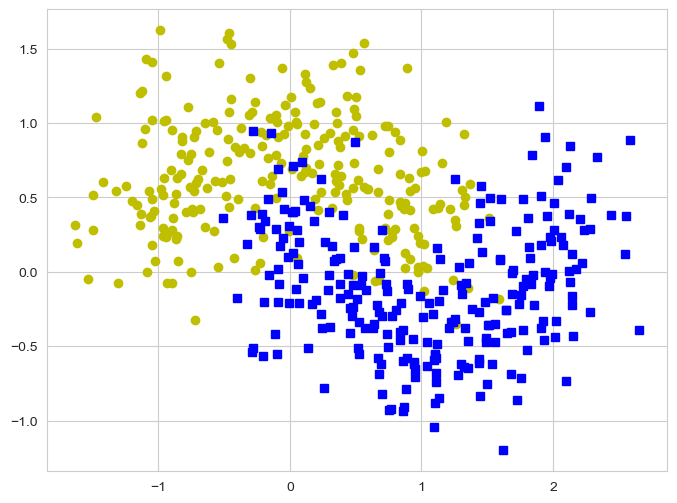

In [11]:
X, y = datasets.make_moons(n_samples=500, noise=0.30, random_state=SEED)

plt.figure(figsize=(8, 6))
plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo")
plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs")
plt.show()

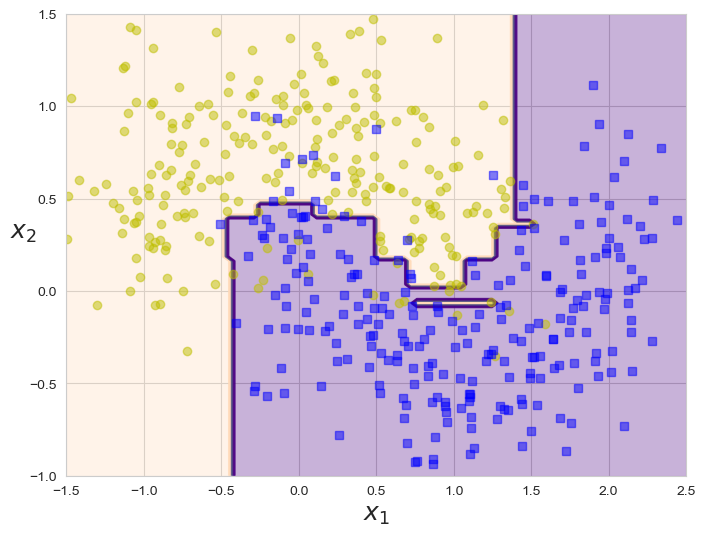

In [12]:
clf = RandomForestClassifierCustom(n_estimators=4, max_depth=5, max_features=2, random_state=SEED)
clf.fit(X, y)

plt.figure(figsize=(8, 6))
plot_decision_boundary(clf, X, y)
plt.show()

Подберите наилучшие гиперпараметры, при которых разделяющая граница будет, на ваш взгляд, оптимальной с точки зрения bias-variance. Можно также подключить какие-то метрики для выбора лучшей модели.

Fitting 6 folds for each of 18 candidates, totalling 108 fits
Лучшие параметры: {'max_depth': 5, 'n_estimators': 50}
Точность лучшей модели: 0.888


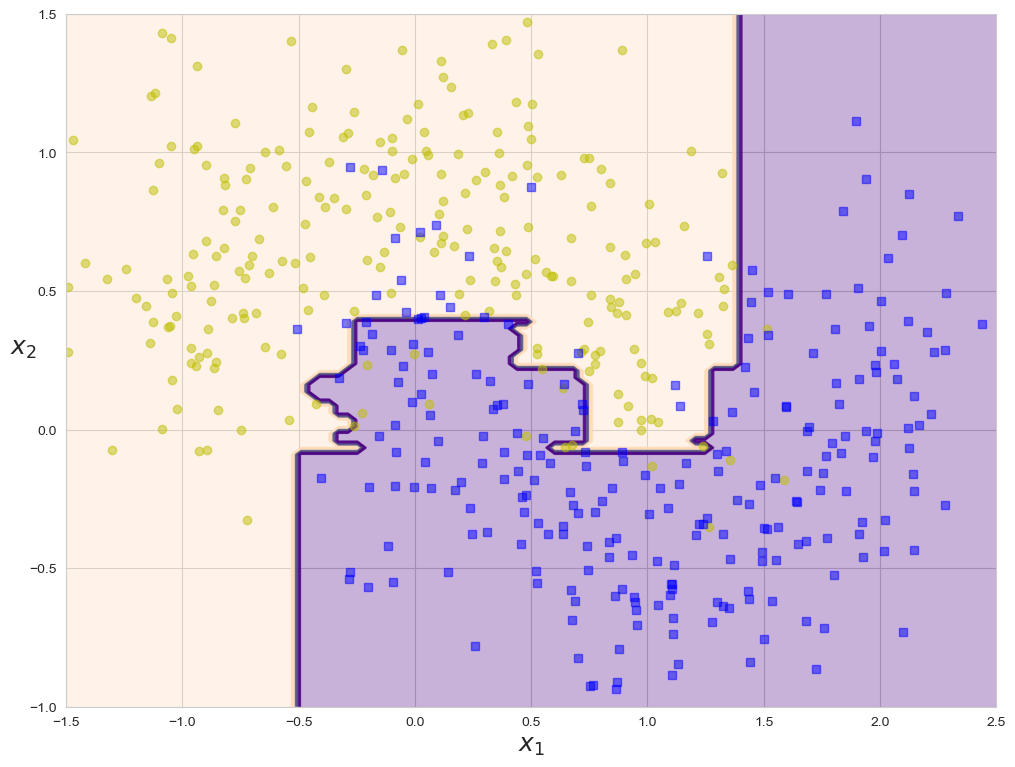

In [13]:
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, make_scorer

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [5, 10, 20, 30, 40, None]
}

rf_custom = RandomForestClassifierCustom()

cv_strategy = StratifiedKFold(n_splits=6)

grid_search = GridSearchCV(estimator=rf_custom, param_grid=param_grid, cv=cv_strategy, scoring=make_scorer(accuracy_score), verbose=1)
grid_search.fit(X_train, y_train)

print('Лучшие параметры:', grid_search.best_params_)

best_rf_custom = grid_search.best_estimator_
y_pred = best_rf_custom.predict(X_test)

print('Точность лучшей модели:', accuracy_score(y_test, y_pred))

plot_decision_boundary(best_rf_custom, X, y)

#### Задание 2. 3. Корреляция базовых моделей

**3 балла**

Как мы выянили на лекции, для того, чтобы bagging работал хорошо, предсказания наших моделей не должны сильно коррелировать. Для этого в случайном лесе применяются различные подходы, в том числе и RSM. Давайте посмотрим, как влияет параметр `max_features` на корреляцию базовых моделей в случайном лесу из `sklearn`. В качестве примера будем использовать датасет `breast_cancer`. Для расчета корреляций используйте приведенную ниже функцию `base_model_pair_correlation`. Для каждой модели у вас будет получаться набор значений (попарные корреляции всех деревьев), дальше можно изобразить их в виде боксплотов, как мы на лекции рисовали распределение метрик.

In [14]:
# Функция для расчета попарных корреляций базовых моделей в случайном лесу
def base_model_pair_correlation(ensemble, X):
    corrs = []
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        ypred_t2 = est2.predict_proba(Xj_test)[:, 1]

        corrs.append(pearsonr(ypred_t1, ypred_t2)[0])
    return np.array(corrs)

In [15]:
# Загрузим данные
breast_cancer = datasets.load_breast_cancer()
X = breast_cancer.data
y = breast_cancer.target
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [16]:
from itertools import combinations
from scipy.stats import pearsonr
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import load_breast_cancer

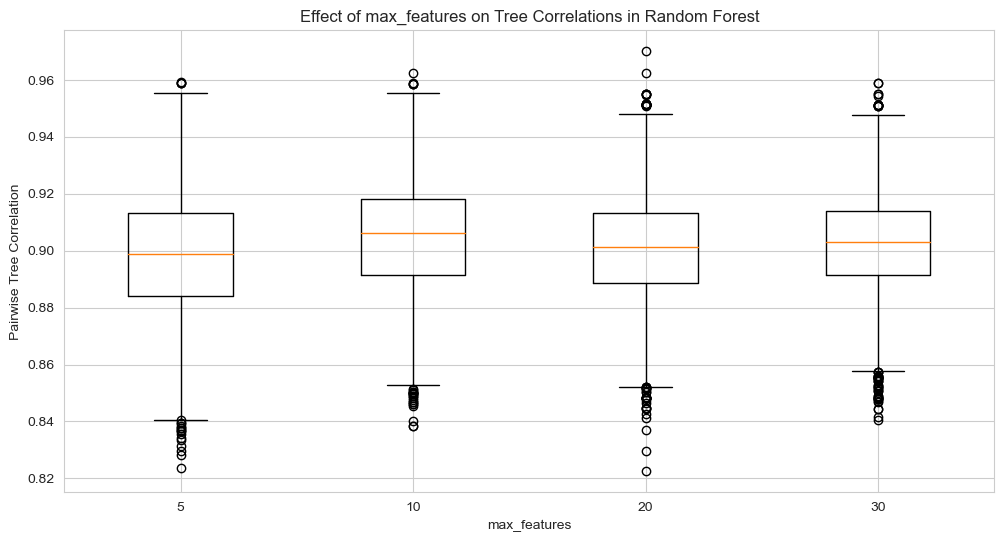

In [17]:
max_features_options = [5, 10, 20, 30]

correlations = {}

for max_features in max_features_options:
    rf = RandomForestClassifier(max_features=max_features)
    rf.fit(X, y)
    corrs = base_model_pair_correlation(rf, X)
    correlations[max_features] = corrs

plt.figure(figsize=(12, 6))
plt.boxplot(correlations.values(), labels=correlations.keys())
plt.xlabel('max_features')
plt.ylabel('Pairwise Tree Correlation')
plt.title('Effect of max_features on Tree Correlations in Random Forest')
plt.show()

Теперь давайте посмотрим, как на это влияет параметр `max_depth`:

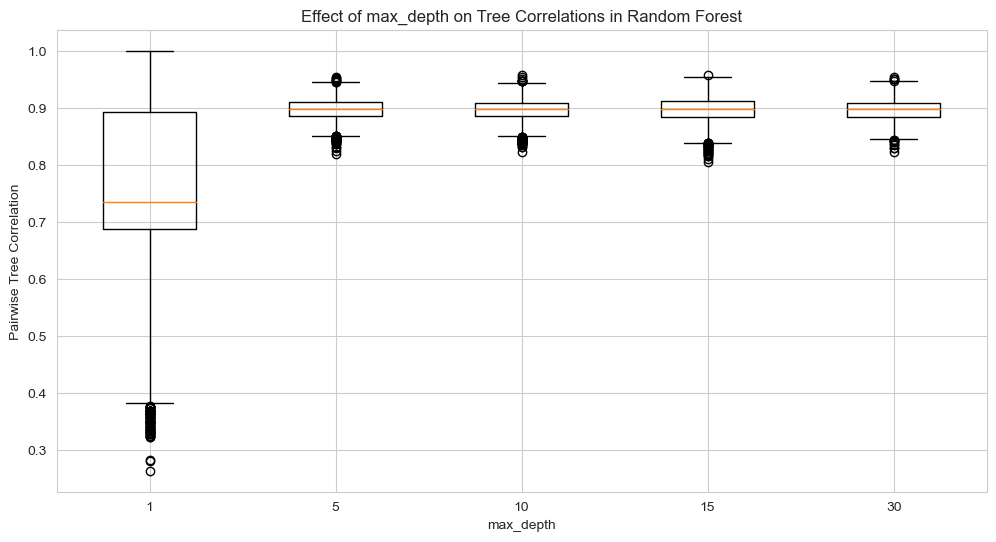

In [18]:
max_depth_options = [1, 5, 10, 15, 30]

correlations = {}

for max_depth in max_depth_options:
    rf = RandomForestClassifier(max_depth=max_depth)
    rf.fit(X, y)
    corrs = base_model_pair_correlation(rf, X)
    correlations[max_depth] = corrs

plt.figure(figsize=(12, 6))
plt.boxplot(correlations.values(), labels=correlations.keys())
plt.xlabel('max_depth')
plt.ylabel('Pairwise Tree Correlation')
plt.title('Effect of max_depth on Tree Correlations in Random Forest')
plt.show()

Опишите ваши наблюдения:

* С увеличением max_features деревья больше начинают коллерировать между собой.

* При небольшом гиперпараметре max_depth значение корреляции между деревьями очень сильно разнятся, модели получаются слишком простые. При бОльших значениях max_depth модели имеют хоть и относительно высокую, но сосредоточенную в одном диапазоне корреляцию между собой.

### Задание 3. Строим большой ансамбль

**4 балла + 3 дополнительных за скор выше 0.87**

В данной задаче вам нужно диагностировать сердечное заболевание у людей по медицинским показателям.

In [19]:
!gdown  --id 1VFbDK-Ad-hpf0_GGCBzn4thdn9mkQ-Y- -O heart.csv -q
heart_dataset = pd.read_csv("heart.csv")

/Users/dara/opt/anaconda3/lib/python3.9/site-packages/gdown/__main__.py:132: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(


In [20]:
X = heart_dataset.drop("target", axis=1)
y = heart_dataset["target"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=SEED)
X_train.head()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal
178,43,1,0,120,177,0,0,120,1,2.5,1,0,3
298,57,0,0,140,241,0,1,123,1,0.2,1,0,3
201,60,1,0,125,258,0,0,141,1,2.8,1,1,3
246,56,0,0,134,409,0,0,150,1,1.9,1,2,3
153,66,0,2,146,278,0,0,152,0,0.0,1,1,2


Обучите разнообразные классификаторы, приведенные ниже, а также ансамбль `VotingClassifier` из `sklearn.ensemble`, объединяющий эти классификаторы с помощью жесткого или мякого голосования (параметр `voting =` `'hard'` или `'soft'` соответственно). Оцените качество моделей с помощью кросс-валидации на тренировочном наборе, используя функцию `cross_val_score` и метрику `f1`. Часть моделей отсюда мы не проходили, о них можно почитать дополнительно, но в принципе для задания не очень важно знать принципы их работы (но, если есть время, то почитайте, там интересно).

In [21]:
dt = DecisionTreeClassifier(random_state=SEED, max_depth=10, min_samples_leaf=10)
rf = RandomForestClassifier(n_estimators=50, random_state=SEED)
etc = ExtraTreesClassifier(random_state=SEED)
knn = KNeighborsClassifier(n_neighbors=5, weights="distance")
svc_lin = SVC(kernel='linear', probability=True, random_state=SEED)
svc_rbf = SVC(kernel='rbf', probability=True, random_state=SEED)
cat = catboost.CatBoostClassifier(verbose=0, random_seed=SEED)
lgbm = lightgbm.LGBMClassifier(random_state=SEED)
lgbm_rf = lightgbm.LGBMClassifier(boosting_type="rf", bagging_freq=1, bagging_fraction=0.7, random_state=SEED)
xgb = xgboost.XGBClassifier(random_state=SEED)
xgb_rf = xgboost.XGBRFClassifier(random_state=SEED)
lr = LogisticRegression(solver='liblinear', max_iter=10000)
nb = GaussianNB()

In [22]:
base_models = [("DT", dt), ("RF", rf), 
               ("ETC", etc), ("KNN", knn), 
               ("SVC_LIN", svc_lin), ("SVC_RBF", svc_rbf), 
               ("CAT", cat), ("LGBM", lgbm), 
               ("LGBM_RF", lgbm_rf), ("XGB", xgb), 
               ("XGB_RF", xgb_rf), ("LR", lr), ("NB", nb)]

In [23]:
from sklearn.ensemble import VotingClassifier

voting_hard = VotingClassifier(estimators=base_models, voting='hard')
voting_soft = VotingClassifier(estimators=base_models, voting = 'soft')

for model in [dt, rf, cat, etc, knn, svc_lin, svc_rbf, xgb, lgbm, xgb_rf, lgbm_rf, lr, nb, voting_hard, voting_soft]: 
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring="f1")
    print(f"{model.__class__.__name__}: {scores.mean()}")

DecisionTreeClassifier: 0.797997226792219
RandomForestClassifier: 0.8328751280279528
CatBoostClassifier: 0.8342715174922052
ExtraTreesClassifier: 0.828174603174603
KNeighborsClassifier: 0.6493313763861709
SVC: 0.8403098469098905
SVC: 0.6973119072190279
XGBClassifier: 0.820158269808819
LGBMClassifier: 0.8170106316447779
XGBRFClassifier: 0.8396975787156666
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_fraction is set=0.7, subsample=1.0 will be ignored. Curr

Вы можете заметить, что ансамбль показывает хорошее, но не лучшее качество предсказания, попробуем его улучшить. Как вы знаете, ансамбли работают лучше, когда модели, входящие в них не скоррелированы друг с другом. Определите корреляцию предсказаний базовых моделей в ансамбле на тестовом наборе данных, и удалите из ансамбля те модели, чьи предсказания будут сильнее коррелировать с остальными. Воспользуйтесь функцией `base_model_pair_correlation_for_voting_clf`. **Спойлер**: далеко не факт, что если вы удалите две модели с корреляцией 0.95, то все станет сильно лучше, здесь все будет немного сложнее. Чтобы добиться максимального качества может понадобиться долгий перебор различных комбинаций моделей. Наилучший скор, который мне удалось достичь, это 0.915, но он получен весьма странной комбинацией алгоритмов, а еще и простым перебором всех вариантов)

In [24]:
def base_model_pair_correlation_for_voting_clf(ensemble, X):
    corrs = []
    base_model_names = [f"{est.__class__.__name__}" for est in ensemble.estimators_]
    for (i, est1), (j, est2) in combinations(enumerate(ensemble.estimators_), 2):
        Xi_test = X
        Xj_test = X

        if not isinstance(est1, SVC):
            ypred_t1 = est1.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t1 = est1.decision_function(Xi_test)


        if not isinstance(est2, SVC):
            ypred_t2 = est2.predict_proba(Xi_test)[:, 1]
        else:
            ypred_t2 = est2.decision_function(Xi_test)
        corrs.append((est1, est2, pearsonr(ypred_t1, ypred_t2)[0]))


    return corrs

In [25]:
for name, model in base_models:
    model.fit(X_train, y_train)

voting_hard_cls = VotingClassifier(estimators=base_models, voting='hard')
voting_hard_cls.fit(X_train, y_train)

voting_soft_cls = VotingClassifier(estimators=base_models, voting='soft')
voting_soft_cls.fit(X_train, y_train)

hard_voting_correlations = base_model_pair_correlation_for_voting_clf(voting_hard_cls, X)
soft_voting_correlations = base_model_pair_correlation_for_voting_clf(voting_soft_cls, X)

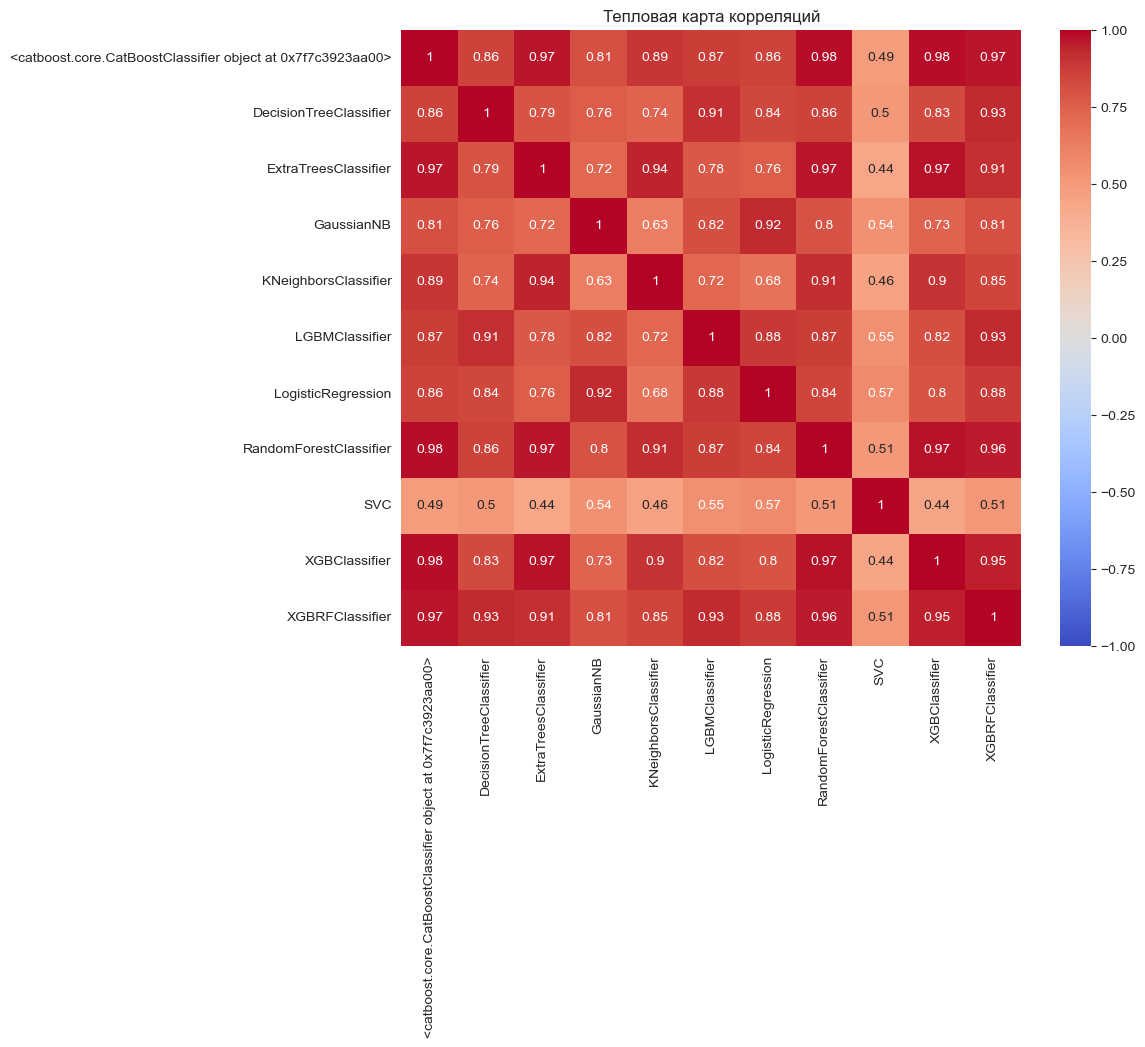

In [26]:
models = [(str(model1).split('(')[0], str(model2).split('(')[0]) for model1, model2, _ in hard_voting_correlations]
correlations = [correlation for _, _, correlation in hard_voting_correlations]

df = pd.DataFrame({'Model 1': [model[0] for model in models],
                   'Model 2': [model[1] for model in models],
                   'Correlation': correlations})

unique_models = sorted(set(df['Model 1']).union(set(df['Model 2'])))
correlation_matrix = np.zeros((len(unique_models), len(unique_models)))

for model1, model2, correlation in hard_voting_correlations:
    idx1 = unique_models.index(str(model1).split('(')[0])
    idx2 = unique_models.index(str(model2).split('(')[0])
    correlation_matrix[idx1, idx2] = correlation
    correlation_matrix[idx2, idx1] = correlation

corr_df = pd.DataFrame(correlation_matrix, columns=unique_models, index=unique_models)
np.fill_diagonal(correlation_matrix, 1)

plt.figure(figsize=(10, 8))
sns.heatmap(corr_df, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Тепловая карта корреляций')
plt.show()

### Задание 4. Определение оттока клиентов из телекома

**6 баллов + 7 дополнительных за высокое качество модели и различные эксперименты**

Будем предсказывать, уйдет ли от нас клиент (переменная `Churn?`). Данные можно скачать [здесь](https://www.kaggle.com/venky12347/churn-telecom). Это будет уже совсем взрослое задание, так как правильного ответа на него нет. Вам нужно будет разобраться с данными, правильно подготовить их для моделей, а также выбрать лучшую модель. 

Задача минимум:

Выберите 2 модели &mdash; один случайный лес и один бустинг из приведенных ниже:

1. `xgboost.XGBClassifier`
2. `xgboost.XGBRFClassifier` &mdash; случайный лес от xgboost
3. `lightgbm.LGBMClassifier`
4. `lightgbm.LGBMClassifier(boosting_type="rf")` &mdash; случайный лес от lightgbm
5. `catboost.CatBoostClassifier`

И попробуйте разобраться с тем, как для этих моделей правильно настраивать гиперпараметры. Советую гуглить примерно следующее `how to choose best hyperparameters for lightgbm`. Там вы найдете кучу сложного и непонятного кода, но если с ним разобраться и научиться обучать нестандартные бустинги, то в плане табличных данных равных вам не будет)

In [33]:
data = pd.read_csv("./churn.csv")
data.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [34]:
print("Int'l Plan", data["Int'l Plan"].unique())
print("VMail Plan", data["VMail Plan"].unique())
print("Churn?", data["Churn?"].unique())
print("State", data["State"].unique())

Int'l Plan ['no' 'yes']
VMail Plan ['yes' 'no']
Churn? ['False.' 'True.']
State ['KS' 'OH' 'NJ' 'OK' 'AL' 'MA' 'MO' 'LA' 'WV' 'IN' 'RI' 'IA' 'MT' 'NY'
 'ID' 'VT' 'VA' 'TX' 'FL' 'CO' 'AZ' 'SC' 'NE' 'WY' 'HI' 'IL' 'NH' 'GA'
 'AK' 'MD' 'AR' 'WI' 'OR' 'MI' 'DE' 'UT' 'CA' 'MN' 'SD' 'NC' 'WA' 'NM'
 'NV' 'DC' 'KY' 'ME' 'MS' 'TN' 'PA' 'CT' 'ND']


In [35]:
data = data.rename(columns={"Int'l Plan": "Intl Plan", "Churn?": "Churn"})
data['Churn'] = data['Churn'].str.replace('.', '')

In [36]:
# Удаляем лишние признаки
data_new = data.drop(['Area Code', 'Phone', 'Day Charge', 'Eve Charge', 'Night Charge', 'Intl Charge'], axis = 1)

In [37]:
X = data_new.drop(['Churn'], axis=1)
y = data_new[['Churn']].replace({'False': 0, 'True': 1})
y = y.astype(bool)

numeric_cols = ['Account Length', 'VMail Message', 'Day Mins', 'Day Calls', 'Eve Mins', 'Eve Calls',  'Night Mins', 'Night Calls', 'Intl Mins', 'Intl Calls', 'CustServ Calls']
categor_cols = ['State', 'Intl Plan', 'VMail Plan']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=SEED)

In [77]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import f1_score

preprocessor = ColumnTransformer(transformers=[
    ('scaler', StandardScaler(), numeric_cols),
    ('ohe', OneHotEncoder(drop='first'), categor_cols)
])

models = [
    ('XGBRFClassifier', xgboost.XGBRFClassifier()),
    ('CatBoostClassifier', catboost.CatBoostClassifier(verbose=False))
]

for model_name, model in models:
    pipe = Pipeline([
        ('preprocessor', preprocessor),
        ('model', model)
    ])
    pipe.fit(X_train, y_train)
    y_pred = pipe.predict(X_test)
    f1 = f1_score(y_test, y_pred)
    print(f'F1-score of {model_name} = {round(f1, 2)}')

F1-score of XGBRFClassifier = 0.75
F1-score of CatBoostClassifier = 0.81


In [55]:
xgbrf = xgboost.XGBRFClassifier(random_state=SEED, n_jobs=-1)

pipe = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgbrf)
])

params = {
    'model__n_estimators': [10, 100, 200],
    'model__max_depth': list(range(1, 41, 5)),
    'model__learning_rate': np.linspace(0.1, 0.5, num=5),
    'model__max_leaves': [0, 10, 20, 30]
}

gscv = GridSearchCV(pipe, param_grid=params, cv=3, scoring='f1', verbose=3)  # Используем f1_macro для многоклассовых данных

gscv.fit(X_train, y_train)

print("Best parameters:", gscv.best_params_)


Fitting 3 folds for each of 480 candidates, totalling 1440 fits
[CV 1/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=10;, score=0.034 total time=   0.0s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=10;, score=0.080 total time=   0.0s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=10;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=100;, score=0.034 total time=   0.1s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=1, model__max_leaves=0, model__n_estimators=200;, score=0.034

[CV 1/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=20, model__n_estimators=200;, score=0.794 total time=   0.2s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=20, model__n_estimators=200;, score=0.800 total time=   0.2s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=20, model__n_estimators=200;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=30, model__n_estimators=10;, score=0.787 total time=   0.0s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=30, model__n_estimators=10;, score=0.806 total time=   0.0s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=30, model__n_estimators=10;, score=0.798 total time=   0.0s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=6, model__max_leaves=30, model__n_estimators=100;, score=0.798 total time=   0.1s
[CV 2/3] END model__learning_rate=0.1

[CV 1/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=100;, score=0.813 total time=   0.3s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=100;, score=0.806 total time=   0.3s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=100;, score=0.790 total time=   0.3s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=200;, score=0.811 total time=   0.5s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=10, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=16, model__max_leaves=20, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning

[CV 1/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=26, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=

[CV 1/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=100;, score=0.806 total time=   0.3s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=100;, score=0.790 total time=   0.3s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.1, model__max_depth=31, model__max_leaves=30, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.1, model__max_depth=36, model__max_leaves=0, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_

[CV 2/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=20, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=20, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=20, model__n_estimators=200;, score=0.034 total time=   0.0s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=20, model__n_estimators=200;, score=0.017 total time=   0.0s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=20, model__n_estimators=200;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=30, model__n_estimators=10;, score=0.034 total time=   0.0s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=1, model__max_leaves=30, model__n_estimators=10;, score=0.080 total time=   0.0s
[CV 3/3] END model__learning_rate=0.

[CV 1/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=100;, score=0.806 total time=   0.1s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=200;, score=0.811 total time=   0.3s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=200;, score=0.806 total time=   0.3s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=10, model__n_estimators=200;, score=0.796 total time=   0.3s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=11, model__max_leaves=20, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning

[CV 1/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=

[CV 1/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=31, model__max_leaves=0, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_

[CV 1/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.2, model__max_depth=36, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning

[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=0, model__n_estimators=200;, score=0.794 total time=   0.2s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=0, model__n_estimators=200;, score=0.800 total time=   0.2s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=0, model__n_estimators=200;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=10, model__n_estimators=10;, score=0.787 total time=   0.0s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=10, model__n_estimators=10;, score=0.806 total time=   0.0s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__max_leaves=10, model__n_estimators=10;, score=0.798 total time=   0.0s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=6, model__

[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=20, model__n_estimators=200;, score=0.811 total time=   0.6s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=20, model__n_estimators=200;, score=0.806 total time=   0.6s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=20, model__n_estimators=200;, score=0.796 total time=   0.5s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=11, model__max_leaves=30, model__n_estimators=10;, score=0.815 total time=   0.0s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=1

[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.5s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.815 total time=   0.0s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=21, 

[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=20, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=20, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=20, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=26, model__max_leaves=30, model__n_estimators=10;, score=0.815 total time=   0.0s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=2

[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, model__max_leaves=10, model__n_estimators=10;, score=0.815 total time=   0.0s
[CV 1/3] END model__learning_rate=0.30000000000000004, model__max_depth=36, 

[CV 2/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=10;, score=0.080 total time=   0.0s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=10;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=100;, score=0.034 total time=   0.0s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=100;, score=0.017 total time=   0.0s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=200;, score=0.034 total time=   0.1s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=1, model__max_leaves=30, model__n_estimators=200;, score=0.017 total time=   0.1s
[CV 3/3] END model__learning_rate=0.

[CV 2/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=10, model__n_estimators=200;, score=0.806 total time=   0.3s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=10, model__n_estimators=200;, score=0.796 total time=   0.3s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=20, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=20, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=20, model__n_estimators=10;, score=0.815 total time=   0.0s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=20, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=11, model__max_leaves=20, model__n_estimators=100;, score=0.806 total time=   0.1s
[CV 3/3] END model__learning_r

[CV 2/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=0, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=0, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=21, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 3/3] END model__learning_rate=

[CV 1/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.806 total time=   0.5s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=26, model__max_leaves=30, model__n_estimators=200;, score=0.796 total time=   0.6s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=31, model__max_leaves=0, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_

[CV 1/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=20, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.4, model__max_depth=36, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning

[CV 2/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=10, model__n_estimators=100;, score=0.806 total time=   0.1s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=10, model__n_estimators=100;, score=0.794 total time=   0.1s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=10, model__n_estimators=200;, score=0.794 total time=   0.2s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=10, model__n_estimators=200;, score=0.800 total time=   0.2s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=10, model__n_estimators=200;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=20, model__n_estimators=10;, score=0.787 total time=   0.0s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=6, model__max_leaves=20, model__n_estimators=10;, score=0.806 total time=   0.0s
[CV 3/3] END model__learning_rate=0.

[CV 1/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=100;, score=0.813 total time=   0.3s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=100;, score=0.806 total time=   0.3s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=0, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=16, model__max_leaves=10, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_rate=

[CV 1/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=21, model__max_leaves=30, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=26, model__max_leaves=0, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning_

[CV 1/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=100;, score=0.813 total time=   0.2s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=100;, score=0.806 total time=   0.2s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=100;, score=0.790 total time=   0.2s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=200;, score=0.811 total time=   0.4s
[CV 2/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=200;, score=0.806 total time=   0.4s
[CV 3/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=20, model__n_estimators=200;, score=0.796 total time=   0.4s
[CV 1/3] END model__learning_rate=0.5, model__max_depth=31, model__max_leaves=30, model__n_estimators=10;, score=0.796 total time=   0.0s
[CV 2/3] END model__learning

In [58]:
gscv.best_estimator_

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('scaler', StandardScaler(),
                                                  ['Account Length',
                                                   'VMail Message', 'Day Mins',
                                                   'Day Calls', 'Eve Mins',
                                                   'Eve Calls', 'Night Mins',
                                                   'Night Calls', 'Intl Mins',
                                                   'Intl Calls',
                                                   'CustServ Calls']),
                                                 ('ohe',
                                                  OneHotEncoder(drop='first'),
                                                  ['State', 'Intl Plan',
                                                   'VMail Plan'])])),
                ('model',
                 XGBRFClassifier(base_score=None, booste...
      

In [57]:
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

F1-score: 0.7637795275590551


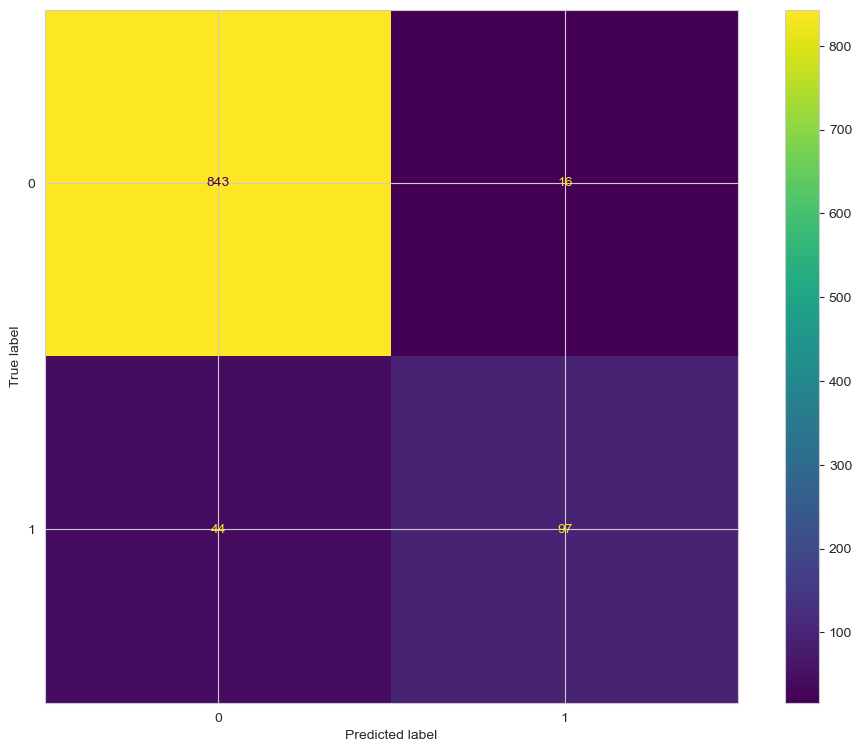

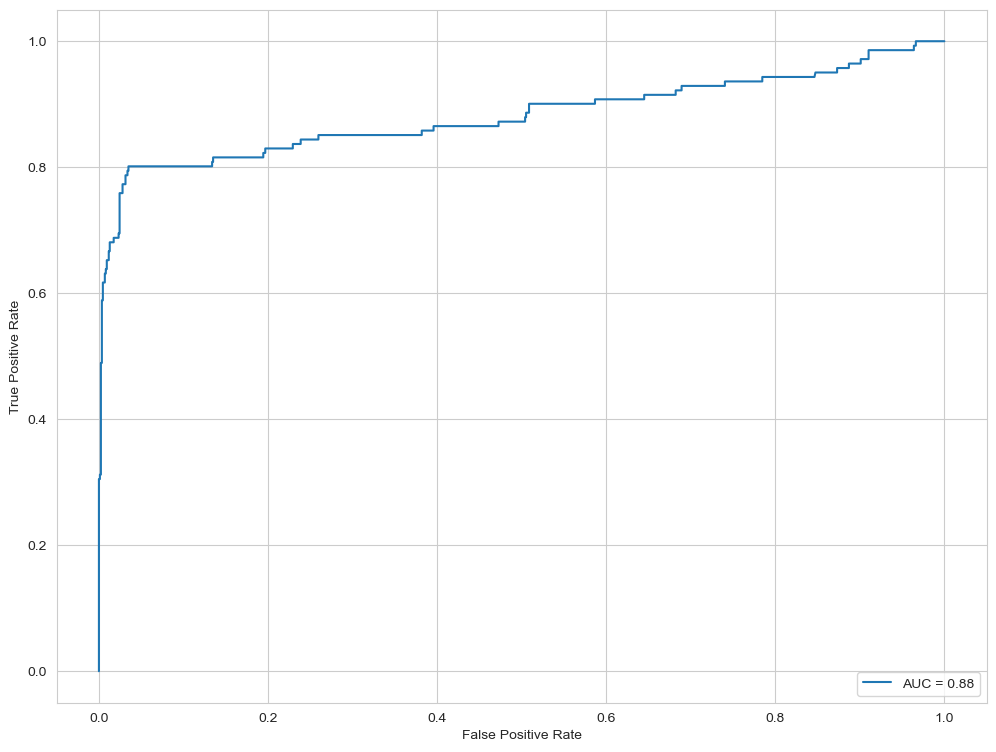

In [59]:
y_prob = best_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

In [72]:
catboost = catboost.CatBoostClassifier(random_state=SEED, verbose=False)
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('model', catboost)])

params = {
    'model__iterations': [50, 100, 200, 300, 500],
    'model__depth': [4, 6, 8, 10],
    'model__learning_rate': [0.01, 0.05, 0.1, 0.2, 0.3]
}

gscv = GridSearchCV(pipe, param_grid=params, cv=5, scoring='f1', verbose=3)

gscv.fit(X_train, y_train)

print("Best parameters:", gscv.best_params_)

Fitting 5 folds for each of 100 candidates, totalling 500 fits
[CV 1/5] END model__depth=4, model__iterations=50, model__learning_rate=0.01;, score=0.137 total time=   0.1s
[CV 2/5] END model__depth=4, model__iterations=50, model__learning_rate=0.01;, score=0.282 total time=   0.1s
[CV 3/5] END model__depth=4, model__iterations=50, model__learning_rate=0.01;, score=0.228 total time=   0.0s
[CV 4/5] END model__depth=4, model__iterations=50, model__learning_rate=0.01;, score=0.208 total time=   0.1s
[CV 5/5] END model__depth=4, model__iterations=50, model__learning_rate=0.01;, score=0.211 total time=   0.1s
[CV 1/5] END model__depth=4, model__iterations=50, model__learning_rate=0.05;, score=0.660 total time=   0.0s
[CV 2/5] END model__depth=4, model__iterations=50, model__learning_rate=0.05;, score=0.735 total time=   0.0s
[CV 3/5] END model__depth=4, model__iterations=50, model__learning_rate=0.05;, score=0.719 total time=   0.0s
[CV 4/5] END model__depth=4, model__iterations=50, model_

[CV 5/5] END model__depth=4, model__iterations=200, model__learning_rate=0.3;, score=0.887 total time=   0.2s
[CV 1/5] END model__depth=4, model__iterations=300, model__learning_rate=0.01;, score=0.727 total time=   0.2s
[CV 2/5] END model__depth=4, model__iterations=300, model__learning_rate=0.01;, score=0.770 total time=   0.2s
[CV 3/5] END model__depth=4, model__iterations=300, model__learning_rate=0.01;, score=0.741 total time=   0.2s
[CV 4/5] END model__depth=4, model__iterations=300, model__learning_rate=0.01;, score=0.709 total time=   0.2s
[CV 5/5] END model__depth=4, model__iterations=300, model__learning_rate=0.01;, score=0.775 total time=   0.2s
[CV 1/5] END model__depth=4, model__iterations=300, model__learning_rate=0.05;, score=0.829 total time=   0.2s
[CV 2/5] END model__depth=4, model__iterations=300, model__learning_rate=0.05;, score=0.831 total time=   0.2s
[CV 3/5] END model__depth=4, model__iterations=300, model__learning_rate=0.05;, score=0.810 total time=   0.2s
[C

[CV 2/5] END model__depth=6, model__iterations=100, model__learning_rate=0.01;, score=0.730 total time=   0.1s
[CV 3/5] END model__depth=6, model__iterations=100, model__learning_rate=0.01;, score=0.636 total time=   0.1s
[CV 4/5] END model__depth=6, model__iterations=100, model__learning_rate=0.01;, score=0.623 total time=   0.1s
[CV 5/5] END model__depth=6, model__iterations=100, model__learning_rate=0.01;, score=0.667 total time=   0.1s
[CV 1/5] END model__depth=6, model__iterations=100, model__learning_rate=0.05;, score=0.807 total time=   0.1s
[CV 2/5] END model__depth=6, model__iterations=100, model__learning_rate=0.05;, score=0.810 total time=   0.1s
[CV 3/5] END model__depth=6, model__iterations=100, model__learning_rate=0.05;, score=0.800 total time=   0.1s
[CV 4/5] END model__depth=6, model__iterations=100, model__learning_rate=0.05;, score=0.793 total time=   0.1s
[CV 5/5] END model__depth=6, model__iterations=100, model__learning_rate=0.05;, score=0.843 total time=   0.1s
[

[CV 2/5] END model__depth=6, model__iterations=500, model__learning_rate=0.01;, score=0.822 total time=   0.6s
[CV 3/5] END model__depth=6, model__iterations=500, model__learning_rate=0.01;, score=0.800 total time=   0.7s
[CV 4/5] END model__depth=6, model__iterations=500, model__learning_rate=0.01;, score=0.813 total time=   0.6s
[CV 5/5] END model__depth=6, model__iterations=500, model__learning_rate=0.01;, score=0.852 total time=   0.5s
[CV 1/5] END model__depth=6, model__iterations=500, model__learning_rate=0.05;, score=0.817 total time=   0.6s
[CV 2/5] END model__depth=6, model__iterations=500, model__learning_rate=0.05;, score=0.833 total time=   0.6s
[CV 3/5] END model__depth=6, model__iterations=500, model__learning_rate=0.05;, score=0.844 total time=   0.6s
[CV 4/5] END model__depth=6, model__iterations=500, model__learning_rate=0.05;, score=0.803 total time=   0.5s
[CV 5/5] END model__depth=6, model__iterations=500, model__learning_rate=0.05;, score=0.873 total time=   0.6s
[

[CV 2/5] END model__depth=8, model__iterations=200, model__learning_rate=0.01;, score=0.794 total time=   0.4s
[CV 3/5] END model__depth=8, model__iterations=200, model__learning_rate=0.01;, score=0.729 total time=   0.4s
[CV 4/5] END model__depth=8, model__iterations=200, model__learning_rate=0.01;, score=0.769 total time=   0.4s
[CV 5/5] END model__depth=8, model__iterations=200, model__learning_rate=0.01;, score=0.800 total time=   0.4s
[CV 1/5] END model__depth=8, model__iterations=200, model__learning_rate=0.05;, score=0.797 total time=   0.4s
[CV 2/5] END model__depth=8, model__iterations=200, model__learning_rate=0.05;, score=0.800 total time=   0.4s
[CV 3/5] END model__depth=8, model__iterations=200, model__learning_rate=0.05;, score=0.800 total time=   0.4s
[CV 4/5] END model__depth=8, model__iterations=200, model__learning_rate=0.05;, score=0.793 total time=   0.4s
[CV 5/5] END model__depth=8, model__iterations=200, model__learning_rate=0.05;, score=0.846 total time=   0.4s
[

[CV 2/5] END model__depth=10, model__iterations=50, model__learning_rate=0.01;, score=0.655 total time=   0.3s
[CV 3/5] END model__depth=10, model__iterations=50, model__learning_rate=0.01;, score=0.604 total time=   0.3s
[CV 4/5] END model__depth=10, model__iterations=50, model__learning_rate=0.01;, score=0.531 total time=   0.3s
[CV 5/5] END model__depth=10, model__iterations=50, model__learning_rate=0.01;, score=0.667 total time=   0.3s
[CV 1/5] END model__depth=10, model__iterations=50, model__learning_rate=0.05;, score=0.745 total time=   0.3s
[CV 2/5] END model__depth=10, model__iterations=50, model__learning_rate=0.05;, score=0.774 total time=   0.3s
[CV 3/5] END model__depth=10, model__iterations=50, model__learning_rate=0.05;, score=0.770 total time=   0.3s
[CV 4/5] END model__depth=10, model__iterations=50, model__learning_rate=0.05;, score=0.684 total time=   0.3s
[CV 5/5] END model__depth=10, model__iterations=50, model__learning_rate=0.05;, score=0.814 total time=   0.3s
[

[CV 1/5] END model__depth=10, model__iterations=300, model__learning_rate=0.01;, score=0.745 total time=   1.5s
[CV 2/5] END model__depth=10, model__iterations=300, model__learning_rate=0.01;, score=0.803 total time=   1.6s
[CV 3/5] END model__depth=10, model__iterations=300, model__learning_rate=0.01;, score=0.754 total time=   1.5s
[CV 4/5] END model__depth=10, model__iterations=300, model__learning_rate=0.01;, score=0.726 total time=   1.5s
[CV 5/5] END model__depth=10, model__iterations=300, model__learning_rate=0.01;, score=0.786 total time=   1.5s
[CV 1/5] END model__depth=10, model__iterations=300, model__learning_rate=0.05;, score=0.761 total time=   1.7s
[CV 2/5] END model__depth=10, model__iterations=300, model__learning_rate=0.05;, score=0.806 total time=   1.6s
[CV 3/5] END model__depth=10, model__iterations=300, model__learning_rate=0.05;, score=0.764 total time=   1.6s
[CV 4/5] END model__depth=10, model__iterations=300, model__learning_rate=0.05;, score=0.813 total time=

In [73]:
best_model = gscv.best_estimator_
y_pred = best_model.predict(X_test)
f1 = f1_score(y_test, y_pred)
print("F1-score:", f1)

F1-score: 0.8031496062992126


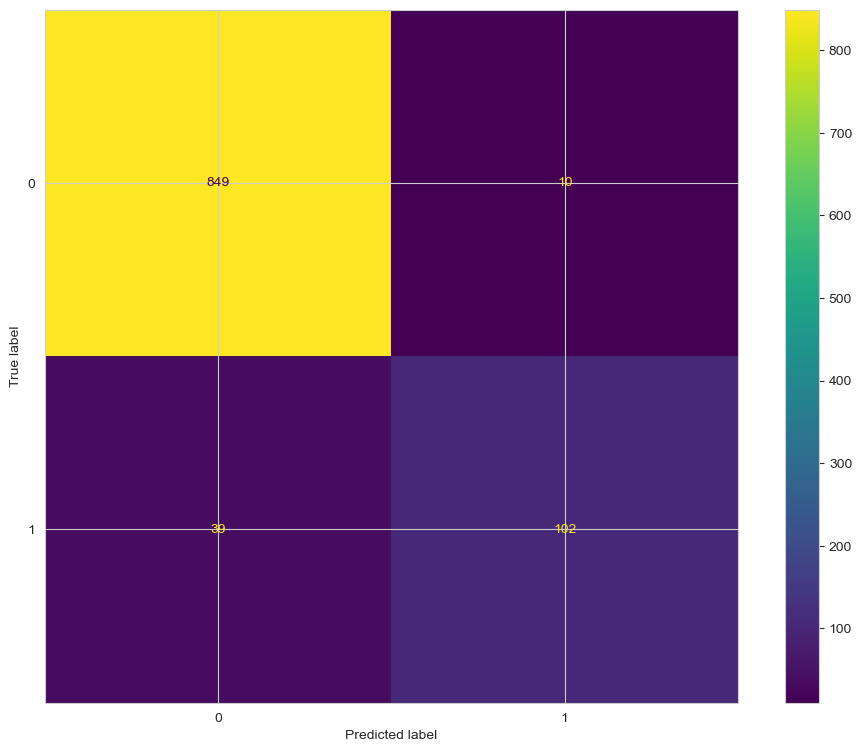

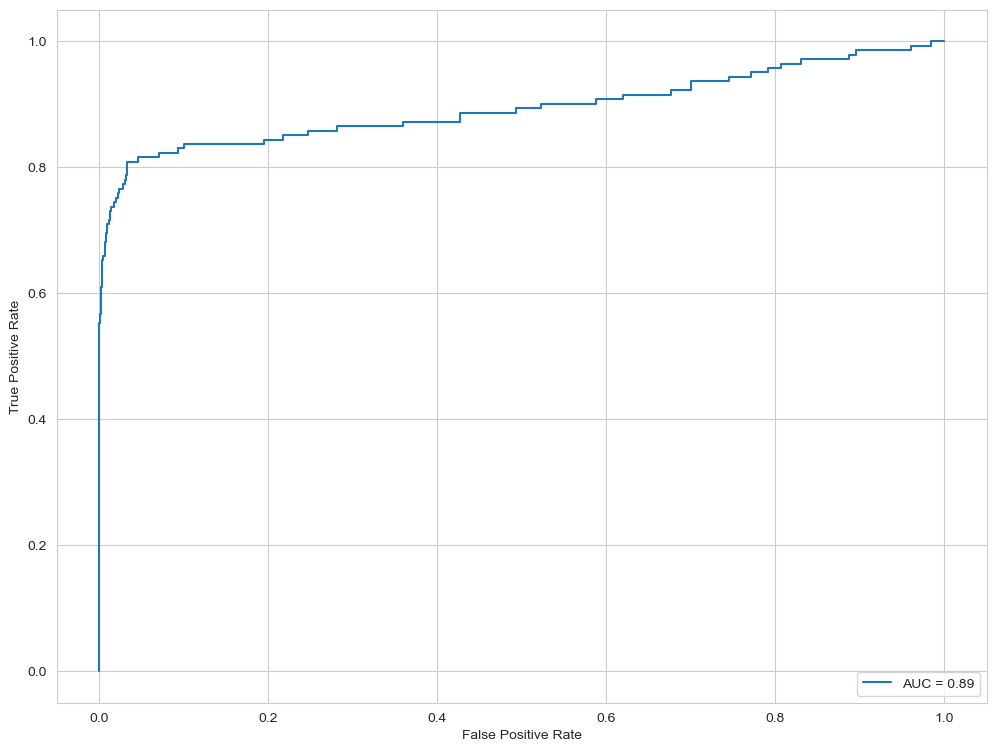

In [78]:
y_prob = best_model.predict_proba(X_test)[:, 1]
cm = confusion_matrix(y_test, y_pred)
ConfusionMatrixDisplay(cm).plot()
roc_auc = roc_auc_score(y_test, y_prob)
fpr, tpr, _ = roc_curve(y_test, y_prob)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
roc_display.plot()

### Задание 5. Рисуем

**дополнительно 0.5 балла**

Наверняка, в процессе выполнения этого задания вас переполняли какие-то эмоции. Нарисуйте что-то, что бы могло бы передать их (я сам не умею, так что, если это будет просто квадрат, тоже подойдет). Прикрепите сюда свой рисунок:

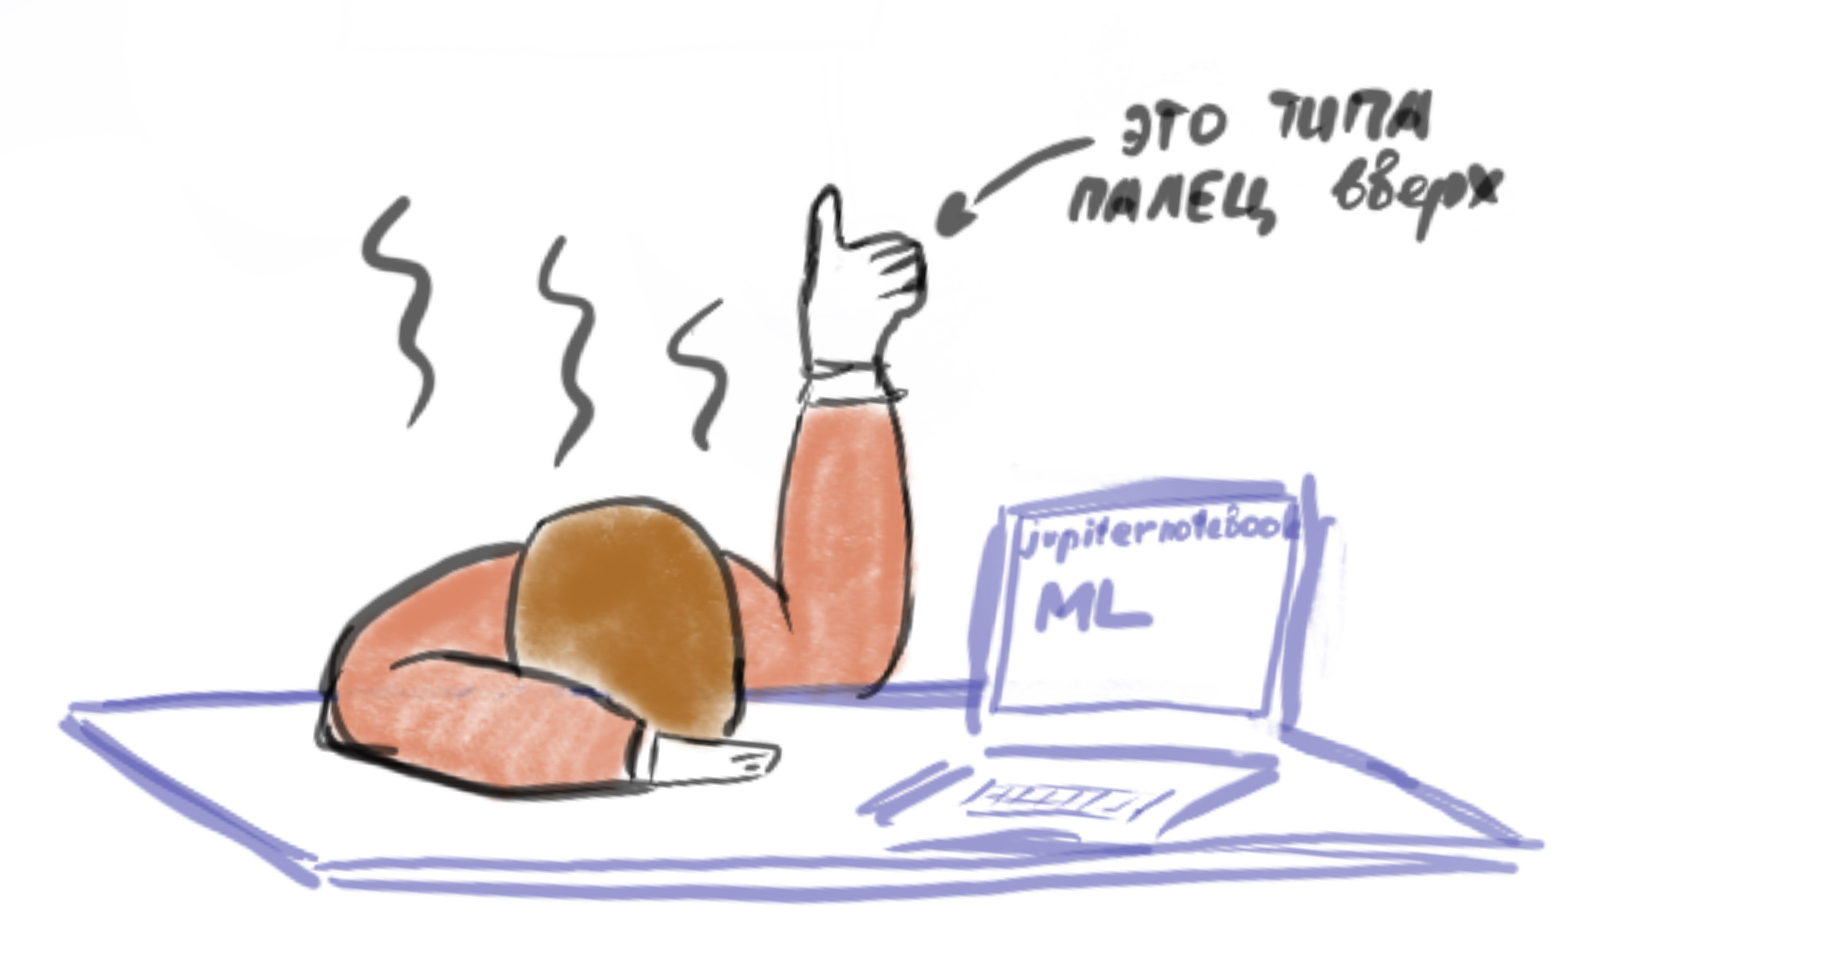

In [80]:
from IPython.display import Image
Image("./IMG_0014.jpg")

### Therapy time

Напишите здесь ваши впечатления о задании (можно и не о задании): было ли интересно, было ли слишком легко или наоборот сложно и тд. Также сюда можно написать свои идеи по улучшению заданий, а также предложить данные, на основе которых вы бы хотели построить следующие дз.

**Ваши мысли:**